### Nikita Puchkin and Valeriia Shcherbakova

### Numerical experiments on the WISDM data set, described in the paper
### "A Contrastive Approach to Online Change Point Detection" (arXiv:2206.10143)

In [1]:
import numpy as np
from sklearn.linear_model import LogisticRegression
import torch
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cvx
from sklearn.metrics.pairwise import pairwise_distances
from scipy.linalg import block_diag

%matplotlib inline

### Online change point detection procedure (polynomials)

In [2]:
# Auxiliary function
# Computation of design matrix based on a linear class
#
# X -- array of univariate observations
#
# p -- positive integer
#
def compute_multivariate_design(X):
    
    Psi = np.append(np.ones((X.shape[0], 1)), X, axis=1)
    
    return Psi

In [3]:
# Auxiliary function
# Computation of the best fitting parameter theta
# under the hypothesis that tau is the true change point
#
# Psi -- (n x p)-array, design matrix 
#
# tau -- change point candidate
#
def compute_theta(Psi, tau):
    
    # Sample size
    t = Psi.shape[0]
    
    # Create "virtual" labels
    Y = np.append(np.ones(tau), -np.ones(t - tau))
    
    lr = LogisticRegression(penalty='none', fit_intercept=False, tol=5e-2,\
                            solver='newton-cg', class_weight='balanced', n_jobs=-1)
    lr.fit(Psi, Y)
    theta = (lr.coef_).reshape(-1)
    
    return theta

In [4]:
# Computation of the test statistic
#
# X -- array of univariate observations
#
# p -- positive integer (used for basis construction)
#
def compute_test_stat_linear(X, threshold, t_min=20, n_out_min=10, B=10, delta_max=50):
    
    # Sample size
    n = X.shape[0]
    
    # Compute design matrix
    Psi = compute_multivariate_design(X)
    
    # Initialization
    T = np.zeros((n, n))
    
    stopping_time = -1
    
    for t in range(t_min, n):
        
        #if (t % 100) == 0:
        #    print('Iteration', t)
            
        D = np.zeros(t)
        
        for tau in range(np.maximum(t - n_out_min - delta_max, n_out_min), t - n_out_min):
            
            # Compute the best fitting parameter theta
            theta = compute_theta(Psi[:t, :], tau)
            Z = Psi[:t, :] @ theta
            
            # Use thresholding to avoid numerical issues
            Z = np.minimum(Z, B)
            Z = np.maximum(Z, -B)
            
            D[:tau] = 2 / (1 + np.exp(-Z[:tau]))
            D[tau:] = 2 / (1 + np.exp(Z[tau:]))
            D = np.log(D)
            
            # Compute statistics for each t
            # and each change point candidate tau
            T[tau, t] = tau * (t - tau) / t * (np.mean(D[:tau]) + np.mean(D[tau:]))
        
        if np.max(T[:, t]) > threshold:
            
            stopping_time = t
            break
            
    # Array of test statistics
    S = np.max(T[:, :stopping_time + 1], axis=0)
    
    return S, stopping_time

### Online change point detection procedure (neural networks)

In [5]:
class NN(nn.Module):
    def __init__(self, n_in, n_out):
        
        super(NN, self).__init__()
        self.act = nn.ReLU()
        self.fc1 = nn.Linear(n_in, 4)
        self.fc2 = nn.Linear(4, 3)
        self.fc3 = nn.Linear(3, n_out)        
    
    def forward(self, x):
        
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        x = self.act(x)
        x = self.fc3(x)
        
        return x

In [6]:
# Computation of the test statistic
#
# X -- array of univariate observations
#
# p -- positive integer (used for basis construction)
#
def compute_test_stat_nn(X, threshold, t_min=20, n_out_min=10, B=10, delta_max=50, n_epochs=200, model=NN):
    
    #X = X.reshape(-1, 1)
    
    # Sample size
    n = X.shape[0]
    
    # Initialization
    T = np.zeros((n, n))
    
    stopping_time = -1
    
    for t in range(t_min, n):
    
        #if (t % 100) == 0:
        #    print('Iteration', t)
            
        for tau in range(np.maximum(t - n_out_min - delta_max, n_out_min), t-n_out_min):
            
            # Initialize neural network
            f = model(n_in=X.shape[1], n_out=1)
            
            # Parameters of the optimizer
            opt = torch.optim.Adam(f.parameters(), lr=1e-1)
            
            X_t = torch.tensor(X[:t, :], dtype=torch.float32, requires_grad=True)
            
            # weights
            W = torch.cat((torch.ones(tau) * (t - tau), torch.ones(t - tau) * tau)).reshape(-1, 1)
            
            # Create "virtual" labels
            Y_t = torch.cat((torch.ones(tau), torch.zeros(t - tau))).reshape(-1, 1)
    
            # Loss function    
            loss_fn = nn.BCEWithLogitsLoss(weight=W)
            
            # Neural network training
            for epoch in range(n_epochs):
                
                loss = loss_fn(f(X_t), Y_t).mean()
                loss.backward()
                opt.step()
                opt.zero_grad()
                
            Z = f(X_t).detach().numpy().reshape(-1)
            
            # Use thresholding to avoid numerical issues
            Z = np.minimum(Z, B)
            Z = np.maximum(Z, -B)
            
            D = np.zeros(t)
            D[:tau] = 2 / (1 + np.exp(-Z[:tau]))
            D[tau:] = 2 / (1 + np.exp(Z[tau:]))
            D = np.log(D)
            
            # Compute statistics for each t
            # and each change point candidate tau
            T[tau, t] = tau * (t - tau) / t * (np.mean(D[:tau]) + np.mean(D[tau:]))
            
        if (np.max(T[:, t]) > threshold):
            
            stopping_time = t
            break
       
    # Array of test statistics
    S = np.max(T[:, :stopping_time + 1], axis=0)
    
    return S, stopping_time

### KLIEP online change point procedure (Sugiyama et al. (2008), Liu et al. (2013))

In [7]:
def compute_test_stat_kliep(X, threshold, window_size=10, sigma=0.1):
    
    if len(X.shape) == 1:
        X = X.reshape(-1, 1)
    
    # More convenient notation
    b = window_size
    
    # Sample size
    n = X.shape[0]
    
    # Initialization
    T = np.zeros(n)
    
    stopping_time = -1
    
    for t in range(2*b + 1, n):
        
        # Test sample
        X_te = X[t-b:t]
        # Reference sample
        X_re = X[t-2*b:t-b]
        
        T[t] = kliep(X_te, X_re, sigma)
        
        if (T[t] > threshold):
            
            stopping_time = t
            break
    
    return T[:stopping_time + 1], stopping_time

In [8]:
def kliep(X_te, X_re, sigma):
    
    # Test sample size
    n_te = X_te.shape[0]
    # Reference sample size
    n_re = X_re.shape[0]
    
    # Compute pairwise distances
    te_te_dist = pairwise_distances(X_te)
    re_te_dist = pairwise_distances(X_re, X_te)
    
    # Compute kernel matrices
    te_te_kernel = np.exp(-0.5 * (te_te_dist / sigma)**2)
    re_te_kernel = np.exp(-0.5 * (re_te_dist / sigma)**2)
    
    # Initialize a vector of coefficients
    theta = cvx.Variable(n_te)
    
    # Objective
    obj = cvx.Maximize(cvx.sum(cvx.log(te_te_kernel @ theta)))
    
    # Constraints
    constraints = [cvx.sum(re_te_kernel @ theta) == n_re, theta >= 0]
    
    # Problem
    prob = cvx.Problem(obj, constraints)
    prob.solve(solver='SCS', max_iters=200, eps=1e-1)
    
    return obj.value

### An online change point detection procedure based on M-statistic (Li, Xie, Dai and Song (2015))

In [9]:
# Compute MMD test statistic
def compute_test_stat_mmd(X, threshold, window_size=10, sigma=0.1):
    
    if len(X.shape) == 1:
        X = X.reshape(-1, 1)
    
    # More convenient notation
    b = window_size
    
    # Sample size
    n = X.shape[0]
    
    # Initialization
    T = np.zeros(n)
    
    stopping_time = -1
    
    for t in range(2*b + 1, n):
        
        # Test sample
        X_te = X[t-b:t, :]
        # Reference sample
        X_re = X[t-2*b:t-b, :]
        
        MMD_2 = mmd_squared(X_re, X_te, sigma)
        var = estimate_variance(X_re, window_size, sigma)
        
        T[t] = MMD_2 / np.sqrt(var)
        
        if (T[t] > threshold):
            
            stopping_time = t
            break
    
    return T[:stopping_time + 1], stopping_time

In [10]:
def mmd_squared(X, Y, sigma):
    
    # Sample size
    n = X.shape[0]
    
    # Compute pairwise distances
    xx_dist = pairwise_distances(X)
    xy_dist = pairwise_distances(X, Y)
    yy_dist = pairwise_distances(Y)
    
    # Compute kernel matrices
    xx_kernel = np.exp(-0.5 * (xx_dist / sigma)**2) - np.identity(n)
    xy_kernel = np.exp(-0.5 * (xy_dist / sigma)**2) - np.identity(n)
    yy_kernel = np.exp(-0.5 * (yy_dist / sigma)**2) - np.identity(n)
    
    # Compute the U-statistic
    u_stat = (np.sum(xx_kernel) - 2 * np.sum(xy_kernel) + np.sum(yy_kernel)) / n / (n - 1)
    
    return u_stat

In [11]:
def h_squared(X, sigma):
    
    # Sample size
    n = X.shape[0]
    
    # Divide the array into four equal parts
    n_max = 4 * (n // 4)
    X_1 = X[0:n_max:4]
    X_2 = X[1:n_max:4]
    X_3 = X[2:n_max:4]
    X_4 = X[3:n_max:4]
    
    K_12 = np.exp(-0.5 * (np.linalg.norm(X_1 - X_2, axis=1) / sigma)**2)
    K_13 = np.exp(-0.5 * (np.linalg.norm(X_1 - X_3, axis=1) / sigma)**2)
    K_24 = np.exp(-0.5 * (np.linalg.norm(X_2 - X_4, axis=1) / sigma)**2)
    K_34 = np.exp(-0.5 * (np.linalg.norm(X_3 - X_4, axis=1) / sigma)**2)
    
    return np.mean((K_12 - K_13 - K_24 + K_34)**2)


# Compute the first term in the variance estimate
def h_cov(X, sigma):
    
    # Sample size
    n = X.shape[0]
    
    # Divide the array into six equal parts
    n_max = 6 * (n // 6)
    X_1 = X[0:n_max:6]
    X_2 = X[1:n_max:6]
    X_3 = X[2:n_max:6]
    X_4 = X[3:n_max:6]
    X_5 = X[4:n_max:6]
    X_6 = X[5:n_max:6]
    
    K_12 = np.exp(-0.5 * (np.linalg.norm(X_1 - X_2, axis=1) / sigma)**2)
    K_13 = np.exp(-0.5 * (np.linalg.norm(X_1 - X_3, axis=1) / sigma)**2)
    K_24 = np.exp(-0.5 * (np.linalg.norm(X_2 - X_4, axis=1) / sigma)**2)
    K_34 = np.exp(-0.5 * (np.linalg.norm(X_3 - X_4, axis=1) / sigma)**2)
    
    K_56 = np.exp(-0.5 * (np.linalg.norm(X_5 - X_6, axis=1) / sigma)**2)
    K_53 = np.exp(-0.5 * (np.linalg.norm(X_5 - X_3, axis=1) / sigma)**2)
    K_64 = np.exp(-0.5 * (np.linalg.norm(X_6 - X_4, axis=1) / sigma)**2)
    K_34 = np.exp(-0.5 * (np.linalg.norm(X_3 - X_4, axis=1) / sigma)**2)
    
    # Compute the second term in the variance estimate
    h_1234 = K_12 - K_13 - K_24 + K_34
    h_5634 = K_56 - K_53 - K_64 + K_34
    
    return np.mean((h_1234 - np.mean(h_1234)) * (h_5634 - np.mean(h_5634)))

# Variance estimate under the null hypothesis
def estimate_variance(X, window_size, sigma):
    
    if len(X.shape) == 1:
        X = X.reshape(-1, 1)
        
    # Sample size
    n = X.shape[0]
    
    # Compute the first term in the variance estimate
    h2 = h_squared(X, sigma) 
    
    # Compute the second term in the variance estimate
    h_c = h_cov(X, sigma)
    
    # Variance estimate
    var = 2 * (h2 + h_c) / window_size / (window_size - 1)
        
    return np.maximum(var, 1e-5)

### WISDM data set

In [12]:
# Read the data
df = pd.read_csv('sample_0.csv')

# Feature vectors
X = np.array(df[['X1', 'X2', 'X3']])
print(X.shape)

# Labels
labels = np.array(df['Label'])
change_points = np.where(labels)[0]

(64868, 3)


In [13]:
# Data preprocessing
# Reduce the data, averaging over 20 values

bandwidth = 20
N = X.shape[0] // bandwidth

data = np.empty((0, 3))
new_labels = np.empty(0)

for t in range(N):
        
    data = np.append(data, np.mean(X[bandwidth * t : bandwidth * (t + 1)], axis=0).reshape(1, -1), axis=0)
    new_labels = np.append(new_labels, np.sum(labels[bandwidth * t : bandwidth * (t + 1)]))
    
change_points = np.where(new_labels)[0]
print(change_points)

# Add the final moment of time the the list of change points
# (for technical purposes only!)
change_points = np.append(change_points, np.array([data.shape[0]]), axis=0)

[ 180  360  540  720  900 1080 1260 1440 1620 1801 1981 2161 2341 2521
 2702 2882 3063]


In [14]:
# Apply the change point detection procedure with the linear class

# Initialization
st_lin = 0
new_st_lin = 0

# the threshold
z_lin = 22

# Initialization of the test statistic
S_lin = np.empty(0)

# Initialization of the list of detected change points
change_points_lin = []


# Initialization of the delays array and
# the false alarms counter
delays_lin = np.empty(0)
current_change_point_ind = 0
false_alarms_lin = 0


while new_st_lin >= 0:
    
    # Run the procedure until the moment
    # it reports a change point occurrence
    new_S_lin, new_st_lin = compute_test_stat_linear(data[st_lin + 1:], z_lin)
    
    S_lin = np.append(S_lin, new_S_lin)
    
    st_lin += new_st_lin
    change_points_lin += [int(st_lin)]
    
    if(new_st_lin > 0):
        print('Detected change point (linear class):', st_lin)
        
    if (st_lin < change_points[current_change_point_ind]):
        false_alarms_lin += 1
    
    else:
        delays_lin = np.append(delays_lin, np.array([st_lin - change_points[current_change_point_ind]]), axis=0)
        current_change_point_ind += 1

print('Linear class. Number of false alarms:', false_alarms_lin, '; average delay:', np.mean(delays_lin),\
     '±', np.std(delays_lin))

Detected change point (linear class): 197
Detected change point (linear class): 377
Detected change point (linear class): 557
Detected change point (linear class): 664
Detected change point (linear class): 742
Detected change point (linear class): 853
Detected change point (linear class): 924
Detected change point (linear class): 1090
Detected change point (linear class): 1278
Detected change point (linear class): 1458
Detected change point (linear class): 1659
Detected change point (linear class): 1805
Detected change point (linear class): 2033
Detected change point (linear class): 2124
Detected change point (linear class): 2189
Detected change point (linear class): 2365
Detected change point (linear class): 2541
Detected change point (linear class): 2719
Detected change point (linear class): 2899
Detected change point (linear class): 3112
Linear class. Number of false alarms: 4 ; average delay: 23.11764705882353 ± 12.294821257659075


In [15]:
# Apply the change point detection procedure
# with the class of neural networks

# Initialization
st_nn = 0
new_st_nn = 0

# the threshold
z_nn = 20

# Initialization of the test statistic
S_nn = np.empty(0)

# Initialization of the list of detected change points
change_points_nn = []


# Initialization of the delays array and
# the false alarms counter
delays_nn = np.empty(0)
current_change_point_ind = 0
false_alarms_nn = 0


while new_st_nn >= 0:
    
    # Run the procedure until the moment
    # it reports a change point occurrence
    new_S_nn, new_st_nn = compute_test_stat_nn(data[st_nn + 1:], z_nn, n_epochs=20)
    
    S_nn = np.append(S_nn, new_S_nn)
    
    st_nn += new_st_nn
    change_points_nn += [int(st_nn)]
    
    if(new_st_nn > 0):
        print('Detected change point (neural networks):', st_nn)
        
    if (st_nn < change_points[current_change_point_ind]):
        false_alarms_nn += 1
    
    else:
        delays_nn = np.append(delays_nn, np.array([st_nn - change_points[current_change_point_ind]]), axis=0)
        current_change_point_ind += 1

print('Neural networks. Number of false alarms:', false_alarms_nn, '; average delay:', np.mean(delays_nn),\
     '±', np.std(delays_nn))

Detected change point (neural networks): 195
Detected change point (neural networks): 373
Detected change point (neural networks): 556
Detected change point (neural networks): 681
Detected change point (neural networks): 744
Detected change point (neural networks): 915
Detected change point (neural networks): 1088
Detected change point (neural networks): 1278
Detected change point (neural networks): 1457
Detected change point (neural networks): 1643
Detected change point (neural networks): 1816
Detected change point (neural networks): 2001
Detected change point (neural networks): 2098
Detected change point (neural networks): 2161
Detected change point (neural networks): 2361
Detected change point (neural networks): 2541
Detected change point (neural networks): 2717
Detected change point (neural networks): 2898
Detected change point (neural networks): 3001
Detected change point (neural networks): 3087
Neural networks. Number of false alarms: 4 ; average delay: 16.41176470588235 ± 5.7400

In [16]:
# Apply the baselines: KLIEP and M-statistic

# Initialization
st_mmd = 0
new_st_mmd = 0

st_kliep = 0
new_st_kliep = 0

# The thresholds
z_mmd = 75
z_kliep = 5

# Initialization of the test statistic
S_mmd = np.empty(0)
S_kliep = np.empty(0)

# Initialization of the list of detected change points
change_points_mmd = []
change_points_kliep = []

# Initialization of the delays array and
# the false alarms counter for M-statistic
delays_mmd = np.empty(0)
current_change_point_ind = 0
false_alarms_mmd = 0


while new_st_mmd >= 0:
    
    new_S_mmd, new_st_mmd = compute_test_stat_mmd(data[st_mmd + 1:], z_mmd, window_size=20, sigma=5)
    
    S_mmd = np.append(S_mmd, new_S_mmd)
    
    st_mmd += new_st_mmd
    change_points_mmd += [int(st_mmd)]
    
    #if(new_st_mmd > 0):
        #print('Detected change point (M-statistic):', st_mmd)
        
    if (st_mmd < change_points[current_change_point_ind]):
        false_alarms_mmd += 1
    
    else:
        delays_mmd = np.append(delays_mmd, np.array([st_mmd - change_points[current_change_point_ind]]), axis=0)
        
        # The M-statistic detector misses the second change point.
        # This line is needed to recalculate detection delays more adequately.
        # If you comment this line, the detection delay will be much larger
        if (current_change_point_ind == 1):
            current_change_point_ind += 1
        
        current_change_point_ind += 1
        
print('M-statistic. Number of false alarms:', false_alarms_mmd, '; average delay:', np.mean(delays_mmd),\
     '±', np.std(delays_mmd))


# Initialization of the delays array and
# the false alarms counter for KLIEP
delays_kliep = np.empty(0)
current_change_point_ind = 0
false_alarms_kliep = 0


while new_st_kliep >= 0:
    
    new_S_kliep, new_st_kliep = compute_test_stat_kliep(data[st_kliep + 1:], z_kliep, window_size=50, sigma=10)
    
    S_kliep = np.append(S_kliep, new_S_kliep)
    
    st_kliep += new_st_kliep
    change_points_kliep += [int(st_kliep)]
    
    if (st_kliep < change_points[current_change_point_ind]):
        false_alarms_kliep += 1
    
    else:
        delays_kliep = np.append(delays_kliep, np.array([st_kliep - change_points[current_change_point_ind]]), axis=0)
        current_change_point_ind = current_change_point_ind + 1
        
print('KLIEP. Number of false alarms:', false_alarms_kliep, '; average delay:', np.mean(delays_kliep),\
     '±', np.std(delays_kliep))
     

M-statistic. Number of false alarms: 7 ; average delay: 30.1875 ± 44.40469956828894
KLIEP. Number of false alarms: 5 ; average delay: 35.1764705882353 ± 49.627121728674375


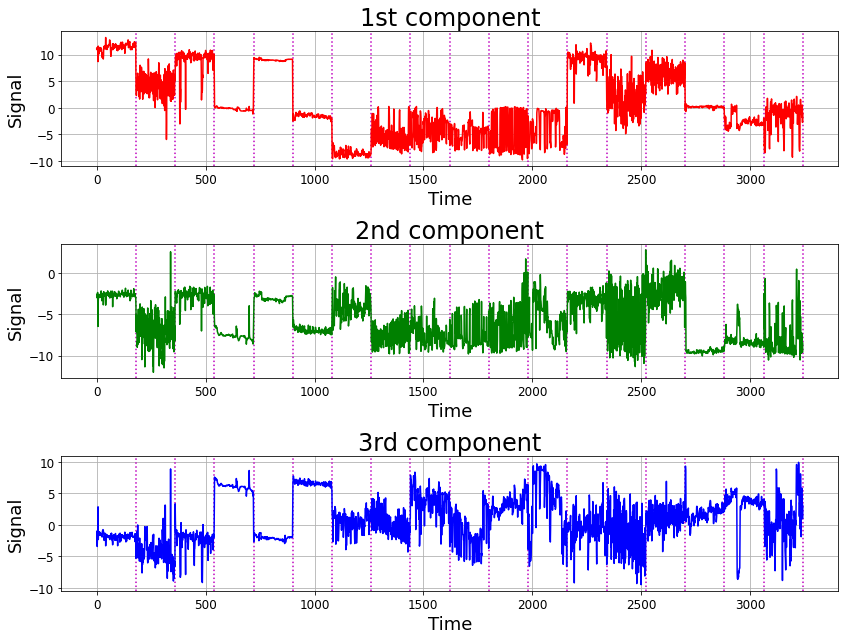

In [17]:
plt.figure(figsize=(12, 9))

plt.subplot(3, 1, 1)

for i in range(len(change_points)):
    plt.axvline(change_points[i], c='m', ls=':')

plt.plot(np.arange(data.shape[0]), data[:, 0], c='r')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(label='1st component', fontsize=24)
plt.xlabel('Time', fontsize
           =18)
plt.ylabel('Signal', fontsize=18)
plt.grid()

plt.subplot(3, 1, 2)

for i in range(len(change_points)):
    plt.axvline(change_points[i], c='m', ls=':')

plt.plot(np.arange(data.shape[0]), data[:, 1], c='g')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(label='2nd component', fontsize=24)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Signal', fontsize=18)
plt.grid()

plt.subplot(3, 1, 3)

for i in range(len(change_points)):
    plt.axvline(change_points[i], c='m', ls=':')

plt.plot(np.arange(data.shape[0]), data[:, 2], c='b')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(label='3rd component', fontsize=24)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Signal', fontsize=18)
plt.grid()

plt.tight_layout()

plt.savefig('images/WISDM.png')

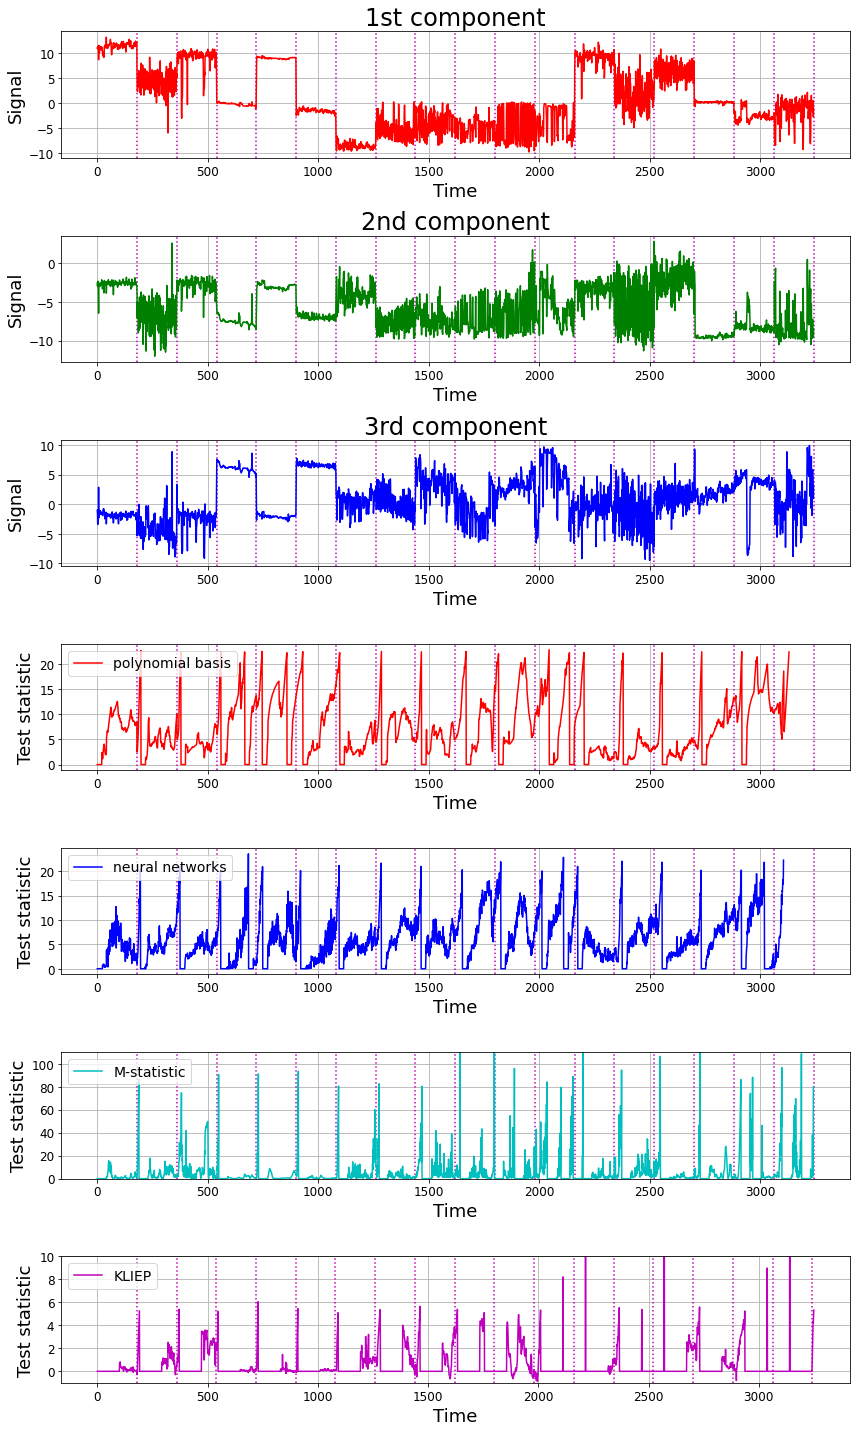

In [18]:
plt.figure(figsize=(12, 20))

plt.subplot(7, 1, 1)

for i in range(len(change_points)):
    plt.axvline(change_points[i], c='m', ls=':')

plt.plot(np.arange(data.shape[0]), data[:, 0], c='r')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(label='1st component', fontsize=24)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Signal', fontsize=18)
plt.grid()

plt.subplot(7, 1, 2)

for i in range(len(change_points)):
    plt.axvline(change_points[i], c='m', ls=':')

plt.plot(np.arange(data.shape[0]), data[:, 1], c='g')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(label='2nd component', fontsize=24)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Signal', fontsize=18)
plt.grid()

plt.subplot(7, 1, 3)

for i in range(len(change_points)):
    plt.axvline(change_points[i], c='m', ls=':')

plt.plot(np.arange(data.shape[0]), data[:, 2], c='b')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(label='3rd component', fontsize=24)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Signal', fontsize=18)
plt.grid()

plt.subplot(7, 1, 4)

for i in range(len(change_points)):
    plt.axvline(change_points[i], c='m', ls=':')
    
plt.plot(S_lin, 'r-', label='polynomial basis')

plt.legend(loc=0, fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Test statistic', fontsize=18)
plt.grid()

plt.subplot(7, 1, 5)

for i in range(len(change_points)):
    plt.axvline(change_points[i], c='m', ls=':')
    
plt.plot(S_nn, 'b-', label='neural networks')

plt.legend(loc=0, fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Test statistic', fontsize=18)
plt.grid()

plt.subplot(7, 1, 6)

for i in range(len(change_points)):
    plt.axvline(change_points[i], c='m', ls=':')
    
plt.plot(S_mmd, 'c-', label='M-statistic')

plt.legend(loc=0, fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Test statistic', fontsize=18)
plt.ylim((0, 110))
plt.grid()

plt.subplot(7, 1, 7)

for i in range(len(change_points)):
    plt.axvline(change_points[i], c='m', ls=':')
    
plt.plot(S_kliep, 'm-', label='KLIEP')

plt.legend(loc=0, fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Test statistic', fontsize=18)
plt.ylim((-1, 10))
plt.grid()

plt.tight_layout()

plt.savefig('images/WISDM_results.png')